# Fraud Detection

Fraud detection is an import application of machine learning. Various machine mearning algorithms can be used to detect frauds (outliers, abnormal samples). Fraud detection can be done in either supervised learning and unsupervised learning. In this notebook, two supervised approaches (neural multipayer perceptron classifier and gradient boosting classifier) and two unsupervised approaches (isolation forest and antoencoder) are used to detect frauds in the credit card transaction data. The dataset is from Kaggle (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

## Data Analysis & Preprocessing

In [185]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

### Load in the data

Load data and display the first 5 rows.

In [186]:
df = pd.read_csv('./data/creditcard.csv')
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    283253
1       473
Name: Class, dtype: int64


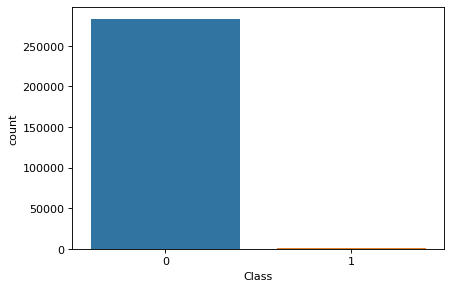

In [187]:
nums = df['Class'].value_counts()
print(nums)
pos_num = nums.loc[1]
plt.figure(dpi = 80)
sns.countplot(data = df, x = 'Class')
plt.show()

We can see that there is 473 positive samples (fraudulent transaction) out of 283253 total transactions (0.167%). The data is extremely imbalanced.

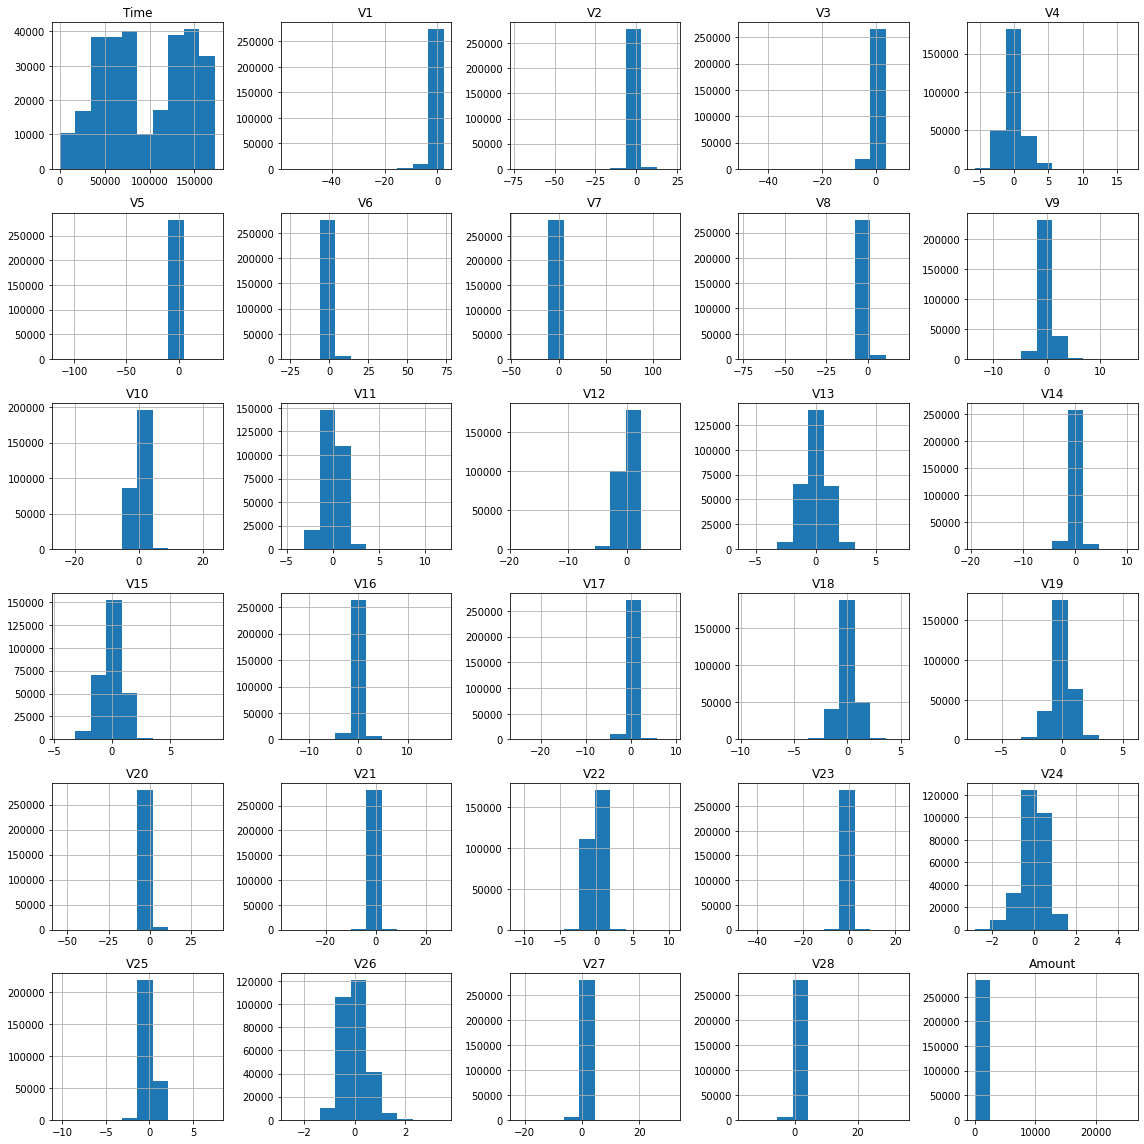

In [188]:
df.hist(column = df.columns[:-1], figsize=(16,16))
plt.tight_layout()
plt.show()

In [189]:
pd.DataFrame({'mean': df.mean(axis = 0).values, 'std': df.std(axis = 0).values}, index = df.columns)

,mean,std
Time,94811.077600,47481.047891
V1,0.005917,1.948026
V2,-0.004135,1.646703
V3,0.001613,1.508682
V4,-0.002966,1.414184
V5,0.001828,1.377008
V6,-0.001139,1.331931
V7,0.001801,1.227664
V8,-0.000854,1.179054
V9,-0.001596,1.095492


From the summary statistics of all the features shown above, we observe that all the principle components (from V1 to V28) are more or less at the same scale and are not far from zero mean and unit standard deviation. However, the ```Time``` and ```Amount``` features are at a much larger scale. Therefore, we standardize the ```Time``` and ```Amount``` features before applying any machine learning models.

In [190]:
class Scaler: 
    
    def __init__(self, df, col_included):   
        self.col_included = col_included     
        self.scaler = StandardScaler()
        self.scaler.fit(df[self.col_included])   
        
    def scale(self, df):
        assert all(col in df.columns for col in self.col_included), 'df doesn\'t contain all the columns to be transformed!'
        df_scaled = df.copy()
        col_scaled = pd.DataFrame(self.scaler.transform(df[self.col_included]), columns = self.col_included)
        df_scaled[self.col_included] = col_scaled[self.col_included]
        df_scaled = df_scaled[df.columns]
        return df_scaled

In [191]:
col_included = ['Time', 'Amount']

scaler = Scaler(df, col_included)

df_scaled = scaler.scale(df)

In [192]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [193]:
df_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996823,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244200,0
1,-1.996823,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342584,0
2,-1.996802,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.158900,0
3,-1.996802,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.139886,0
4,-1.996781,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073813,0


## Supervised Learning Approach

### Data preparation

In [194]:
from sklearn.model_selection import train_test_split

For supervised machine learning model, in order to have a balanced training dataset, we undersample the data. Concretely, we firstly sample 80% of the positive samples (that is 0.8 * 473 = 378) and the same amount of negative samples (378) to form a balanced training + val set. The rest of the data is used as the test set. Then we split 10% data out from the training + val set to be the val data and the rest 90% is the training data.

In [195]:
def data_split_undersampling(df):
    """
            Undersample the data such that: 
        train + val: 80% of the positive samples and the same number of negative samples
        test: the rest of the positive and negative samples
        where positive samples are outliers and negative samples are inliers.
    """
    df_pos = df[df['Class'] == 1]
    df_neg = df[df['Class'] == 0]
    df_test = df_pos.sample(frac = 0.2)
    df_train_val = df_pos.drop(df_test.index)
    num_pos_train_val = len(df_train_val)
    df_train_val_neg = df_neg.sample(num_pos_train_val)
    df_train_val = pd.concat([df_train_val, df_train_val_neg])
    df_test = pd.concat([df_test, df_neg.drop(df_train_val_neg.index)])
    return df_train_val, df_test

In [196]:
df_train_val, df_test = data_split_undersampling(df_scaled)
print(f"The number of training&val samples: {len(df_train_val)}, with {len(df_train_val[df_train_val['Class'] == 1])} positive and {len(df_train_val[df_train_val['Class'] == 0])} negative")
print(f"The number of test samples: {len(df_test)}, with {len(df_test[df_test['Class'] == 1])} positive and {len(df_test[df_test['Class'] == 0])} negative")


The number of training&val samples: 756, with 378 positive and 378 negative
The number of test samples: 282970, with 95 positive and 282875 negative


In [197]:
X_train_val = df_train_val.drop(columns = ['Class'])
y_train_val = df_train_val['Class']
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1, random_state = 42)
X_test = df_test.drop(columns = ['Class'])
y_test = df_test['Class']
print(f"The number of training samples: {len(X_train)}, the number of val samples: {len(X_val)}")


The number of training samples: 680, the number of val samples: 76


### Neural network

In [198]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

We build a neural network classifier composed of multilayer perceptrons to classify the positive and negative samples. The training set is fed to the network for training and val set is used to evaluate the performance of the network during training. The test set is used to finally evaluate the network after training.

In [199]:
inputs = Input(shape = (30,))
hidden = Dense(16, activation = 'relu')(inputs)
hidden = Dense(8, activation = 'relu')(inputs)
hidden = Dropout(0.2)(hidden)
hidden = Dense(4, activation = 'relu')(inputs)
hidden = Dropout(0.2)(hidden)
outputs = Dense(1, activation = 'sigmoid')(hidden)
model = Model(inputs = inputs, outputs = outputs)

print(model.summary())

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
dense_52 (Dense)             (None, 4)                 124       
_________________________________________________________________
dropout_25 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 5         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________
None


In [200]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.keras.metrics.BinaryAccuracy()
model.compile(optimizer = 'adam', loss = loss, metrics = [metrics])

In [201]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 20, verbose = 1)
history = model.fit(x = X_train,
                    y = y_train,
                    batch_size = 32,
                    epochs = 200,
                    validation_data = (X_val, y_val),
                    callbacks = [callback])

Epoch 1/200
22/22 [==============================] - 1s 16ms/step - loss: 0.7721 - binary_accuracy: 0.6154 - val_loss: 0.7163 - val_binary_accuracy: 0.6162
Epoch 2/200
22/22 [==============================] - 0s 2ms/step - loss: 0.6580 - binary_accuracy: 0.6271 - val_loss: 0.6697 - val_binary_accuracy: 0.6429
Epoch 3/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5846 - binary_accuracy: 0.6475 - val_loss: 0.6333 - val_binary_accuracy: 0.6546
Epoch 4/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5249 - binary_accuracy: 0.6588 - val_loss: 0.6025 - val_binary_accuracy: 0.6639
Epoch 5/200
22/22 [==============================] - 0s 2ms/step - loss: 0.5472 - binary_accuracy: 0.6665 - val_loss: 0.5727 - val_binary_accuracy: 0.6718
Epoch 6/200
22/22 [==============================] - 0s 2ms/step - loss: 0.4980 - binary_accuracy: 0.6744 - val_loss: 0.5477 - val_binary_accuracy: 0.6786
Epoch 7/200
22/22 [==============================] - 0s 2ms/step - lo

22/22 [==============================] - 0s 2ms/step - loss: 0.2024 - binary_accuracy: 0.8721 - val_loss: 0.2313 - val_binary_accuracy: 0.8731
Epoch 54/200
22/22 [==============================] - 0s 2ms/step - loss: 0.2181 - binary_accuracy: 0.8734 - val_loss: 0.2283 - val_binary_accuracy: 0.8743
Epoch 55/200
22/22 [==============================] - 0s 2ms/step - loss: 0.1851 - binary_accuracy: 0.8747 - val_loss: 0.2267 - val_binary_accuracy: 0.8755
Epoch 56/200
22/22 [==============================] - 0s 2ms/step - loss: 0.2157 - binary_accuracy: 0.8757 - val_loss: 0.2249 - val_binary_accuracy: 0.8765
Epoch 57/200
22/22 [==============================] - 0s 2ms/step - loss: 0.1990 - binary_accuracy: 0.8768 - val_loss: 0.2220 - val_binary_accuracy: 0.8776
Epoch 58/200
22/22 [==============================] - 0s 2ms/step - loss: 0.2014 - binary_accuracy: 0.8778 - val_loss: 0.2204 - val_binary_accuracy: 0.8786
Epoch 59/200
22/22 [==============================] - 0s 2ms/step - loss: 0.1

22/22 [==============================] - 0s 2ms/step - loss: 0.1422 - binary_accuracy: 0.9063 - val_loss: 0.1569 - val_binary_accuracy: 0.9066
Epoch 106/200
22/22 [==============================] - 0s 2ms/step - loss: 0.1513 - binary_accuracy: 0.9067 - val_loss: 0.1574 - val_binary_accuracy: 0.9070
Epoch 107/200
22/22 [==============================] - 0s 2ms/step - loss: 0.1453 - binary_accuracy: 0.9071 - val_loss: 0.1566 - val_binary_accuracy: 0.9074
Epoch 108/200
22/22 [==============================] - 0s 2ms/step - loss: 0.1578 - binary_accuracy: 0.9075 - val_loss: 0.1563 - val_binary_accuracy: 0.9077
Epoch 109/200
22/22 [==============================] - 0s 2ms/step - loss: 0.1479 - binary_accuracy: 0.9078 - val_loss: 0.1559 - val_binary_accuracy: 0.9081
Epoch 110/200
22/22 [==============================] - 0s 2ms/step - loss: 0.1312 - binary_accuracy: 0.9082 - val_loss: 0.1549 - val_binary_accuracy: 0.9083
Epoch 111/200
22/22 [==============================] - 0s 2ms/step - los

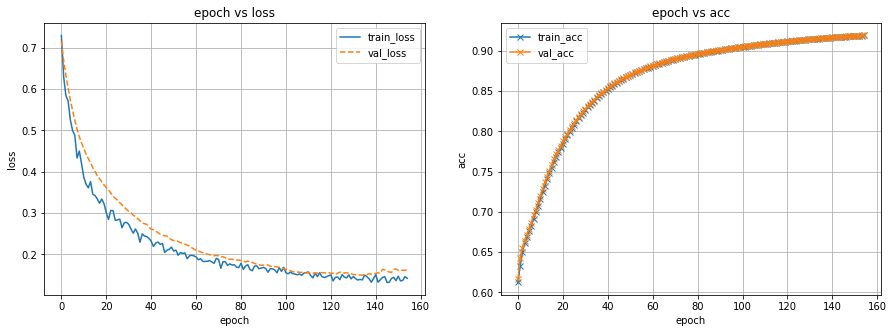

In [202]:
fig = plt.figure(figsize = (15, 5))

# ====== Plot Loss ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(history.history["loss"], label = 'train_loss')
ax1.plot(history.history["val_loss"], '--', label = 'val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Plot Metric ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(history.history["binary_accuracy"], marker = 'x', label = 'train_acc')
ax2.plot(history.history["val_binary_accuracy"], marker = 'x', label = 'val_acc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs acc')

plt.show()

In [203]:
y_prob = model.predict(X_test)
y_pred = [0 if prob < 0.5 else 1 for prob in y_prob]
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n Recall: {recall_score(y_test, y_pred)}\n Precision: {precision_score(y_test, y_pred)}\n F1 score: {f1_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))
      

Accuracy: 0.9647206417641446
 Recall: 0.9263157894736842
 Precision: 0.008744038155802861
 F1 score: 0.01732453981691111
[[272899   9976]
 [     7     88]]


### Gradient Boosting

In [204]:
from sklearn.ensemble import GradientBoostingClassifier

Here, we use the training data to fit the model, val data to tune the hyperparameter ```max_depth``` and test set to evaluate the final performance.

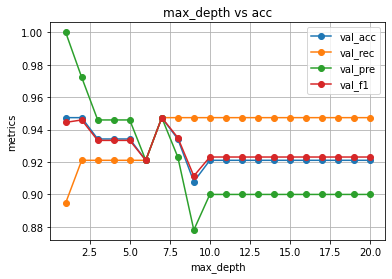

In [205]:
trial_depth = list(range(1, 21, 1))
GB_acc_list = []
GB_rec_list = []
GB_pre_list = []
GB_f1_list = []

for depth in trial_depth:
    clf = GradientBoostingClassifier(max_depth = depth, random_state = 0).fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    GB_acc_list.append(accuracy_score(y_val, y_pred))
    GB_rec_list.append(recall_score(y_val, y_pred))
    GB_pre_list.append(precision_score(y_val, y_pred))
    GB_f1_list.append(f1_score(y_val, y_pred))
     
fig = plt.figure()

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(trial_depth, GB_acc_list, marker = 'o', label = 'val_acc')
ax1.plot(trial_depth, GB_rec_list, marker = 'o', label = 'val_rec')
ax1.plot(trial_depth, GB_pre_list, marker = 'o', label = 'val_pre')
ax1.plot(trial_depth, GB_f1_list, marker = 'o', label = 'val_f1')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('metrics')
ax1.grid()
ax1.legend()
ax1.set_title('max_depth vs acc')

plt.show()

It seems like ```max_depth = 2``` and ```max_depth = 7``` the model achieves similar performence on the val set. We just choose ```max_depth = 2```.

In [208]:
clf = GradientBoostingClassifier(max_depth = 2, random_state = 0).fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n Recall: {recall_score(y_test, y_pred)}\n Precision: {precision_score(y_test, y_pred)}\n F1 score: {f1_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9544156624377143
 Recall: 0.9263157894736842
 Precision: 0.006779661016949152
 F1 score: 0.013460803059273422
[[269983  12892]
 [     7     88]]


## Unsupervised Learning Approach

### Isolation forest

In [279]:
from sklearn.ensemble import IsolationForest

We use 90% of the total data as the training set and the rest 10% as the test set.

In [280]:
df_test = df_scaled.sample(frac = 0.1)
df_train = df_scaled.drop(df_test.index)
print(f"The number of training samples: {len(df_train)}, with {len(df_train[df_train['Class'] == 1])} positive and {len(df_train[df_train['Class'] == 0])} negative")
print(f"The number of test samples: {len(df_test)}, with {len(df_test[df_test['Class'] == 1])} positive and {len(df_test[df_test['Class'] == 0])} negative")


The number of training samples: 255353, with 424 positive and 254929 negative
The number of test samples: 28373, with 49 positive and 28324 negative


In [281]:
X_train = df_train.drop(columns = ['Class'])
y_train = df_train['Class']
X_test = df_test.drop(columns = ['Class'])
y_test = df_test['Class']
print(f"Positive rate of training samples: {y_train.values.sum() / len(y_train): .2%}")


Positive rate of training samples:  0.17%


We test out different value for the ```contamination``` parameter and use the one that tends to give the best performence on the training data.

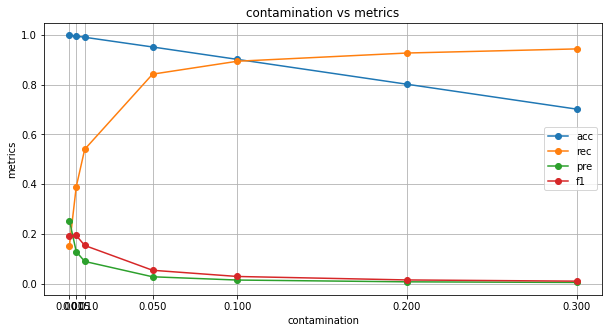

In [282]:
trial_con = [0.3, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]
IF_acc_list = []
IF_rec_list = []
IF_pre_list = []
IF_f1_list = []

for con in trial_con:
    y_pred = IsolationForest(random_state = 0, contamination = con).fit_predict(X_train)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    IF_acc_list.append(accuracy_score(y_train, y_pred))
    IF_rec_list.append(recall_score(y_train, y_pred))
    IF_pre_list.append(precision_score(y_train, y_pred))
    IF_f1_list.append(f1_score(y_train, y_pred))
    
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(trial_con, IF_acc_list, marker = 'o', label = 'acc')
ax1.plot(trial_con, IF_rec_list, marker = 'o', label = 'rec')
ax1.plot(trial_con, IF_pre_list, marker = 'o', label = 'pre')
ax1.plot(trial_con, IF_f1_list, marker = 'o', label = 'f1')
ax1.set_xticks(trial_con)
ax1.set_xlabel('contamination')
ax1.set_ylabel('metrics')
ax1.grid()
ax1.legend()
ax1.set_title('contamination vs metrics')

plt.show()

In [283]:
clf = IsolationForest(random_state = 0, contamination = 0.11).fit(X_train)

y_pred = clf.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n Recall: {recall_score(y_test, y_pred)}\n Precision: {precision_score(y_test, y_pred)}\n F1 score: {f1_score(y_test, y_pred)}')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8912346244669228
 Recall: 0.9183673469387755
 Precision: 0.014390789894467541
 F1 score: 0.028337531486146098
[[25242  3082]
 [    4    45]]


### Autoencoder

In [295]:
import torch
import time
import argparse
import random

For the fraud detector based on autoencoder, the idea is that we train the autoencoder only with negative samples and when it sees a positive sample it will have a higher reconstruction error than usual. Thus, we use 80% of the negative samples to be the training + val set and the rest 20% of negative samples plus all the positive samples to be the test set. Further, we use 30% of the test data (test_1) to select an appropriate threshold for reconstruction error and use the rest 70% to give a final evaluation of the model performence.

In [296]:
def data_split_autoencoder(df):
    """
            Undersample the data such that: 
        train + val: 80% of the negtive samples
        test: all of the positive samples and 20% of the negative samples
        where positive samples are outliers and negative samples are inliers.
    """
    df_pos = df[df['Class'] == 1]
    df_neg = df[df['Class'] == 0]
    df_test = df_neg.sample(frac = 0.2)
    df_train_val = df_neg.drop(df_test.index)
    df_test = pd.concat([df_test, df_pos])
    return df_train_val, df_test

In [297]:
df_train_val, df_test = data_split_autoencoder(df_scaled)
print(f"The number of training&val samples: {len(df_train_val)}, with {len(df_train_val[df_train_val['Class'] == 1])} positive and {len(df_train_val[df_train_val['Class'] == 0])} negative")
print(f"The number of test samples: {len(df_test)}, with {len(df_test[df_test['Class'] == 1])} positive and {len(df_test[df_test['Class'] == 0])} negative")


The number of training&val samples: 226602, with 0 positive and 226602 negative
The number of test samples: 57124, with 473 positive and 56651 negative


In [298]:
X_train_val = df_train_val.drop(columns = ['Class'])
y_train_val = df_train_val['Class']
X_train, X_val, _, _ = train_test_split(X_train_val, y_train_val, test_size = 0.1, random_state = 42)
X_test = df_test.drop(columns = ['Class'])
y_test = df_test['Class']

num_train = len(X_train)
num_val = len(X_val)

print(f"The number of training samples: {num_train}, the number of val samples: {num_val}")


The number of training samples: 203941, the number of val samples: 22661


In [299]:
class AEDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        super().__init__()
        self.X = X
        self.y = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (torch.tensor(self.X.iloc[idx], dtype = torch.float32), torch.tensor(self.X.iloc[idx], dtype = torch.float32))


In [300]:
train_dataset = AEDataset(X_train)
val_dataset = AEDataset(X_val)


In [268]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 5)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(5, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 30)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [269]:
def experiment(train_dataset, val_dataset, args):
    model = Autoencoder()
    
    print(model)
    
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = args.batch_size, shuffle = False)
    
    if args.gpu:
        # ****** Copy model to device ****** #
        model.to(device)
  
    # ====== Loss function ====== #
    lossfunction = torch.nn.MSELoss(reduction = 'sum')
    
    optimizer = torch.optim.Adam(model.parameters())
    
    # ====== Data collection ====== #
    list_epoch = [] 
    list_train_loss = []
    list_val_loss = []
    list_train_acc = []
    list_val_acc = []
    
    # ====== Loop ====== #
    for epoch in range(args.epoch):  
        
        t0 = time.time()
        # ====== Train ====== #
        model.train() # Set the model be 'train mode' 
        train_loss = 0 # to sum up each batch
        
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = args.batch_size, shuffle = True)
        
        for batch_X, batch_y in train_dataloader:
            
            if args.gpu:
                # ****** Transfer data to GPU ****** #
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

            pred_y = model(batch_X)
            
            loss = lossfunction(pred_y, batch_y)
            
            optimizer.zero_grad()

            loss.backward()
            
            optimizer.step()
            
            train_loss += loss.item()
                          
        train_loss = train_loss / (30 * num_train)
        list_train_loss.append(train_loss)
        list_epoch.append(epoch)
           
        print(f'{time.time() - t0} seconds')
        
        # ====== Validation ====== #
        model.eval() # Set the model be 'evaluate mode' 
        val_loss = 0 # to sum up each batch
                         
        with torch.inference_mode():
            
            for batch_X, batch_y in val_dataloader:
        
                if args.gpu:
                    # ****** Transfer data to GPU ****** #
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)

                pred_y = model(batch_X)
                
                loss = lossfunction(pred_y, batch_y)
                
                val_loss += loss.item()
                
        val_loss = val_loss / (30 * num_val)
        list_val_loss.append(val_loss)

        print(f'Epoch: {epoch}, Train Loss: {train_loss: .4f}, Val Loss: {val_loss: .4f}')
        print('~' * 100)
        
        torch.save(model.state_dict(), './AE model/model.pt')
        
    return list_epoch, list_train_loss, list_val_loss

In [270]:
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.gpu = False
args.epoch = 30
args.batch_size = 128

train_dataset = AEDataset(X_train)
val_dataset = AEDataset(X_val)

list_epoch, list_train_loss, list_val_loss = experiment(train_dataset, val_dataset, args)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=30, bias=True)
  )
)
62.946115016937256 seconds
Epoch: 0, Train Loss:  0.6069, Val Loss:  0.4661
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
63.022467851638794 seconds
Epoch: 1, Train Loss:  0.4172, Val Loss:  0.3985
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
62.84077024459839 seconds
Epoch: 2, Train Loss:  0.3857, Val Loss:  0.3801
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

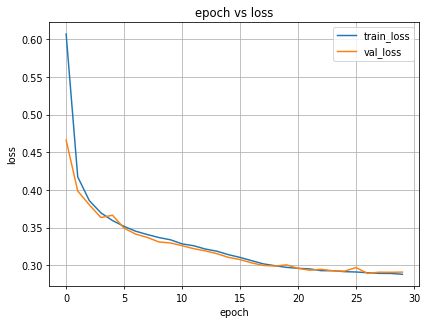

In [271]:
fig = plt.figure(figsize = (15, 5), dpi = 70)

# ====== Plot Loss ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

plt.show()

In [307]:
X_test_1, X_test_2, y_test_1, y_test_2 = train_test_split(X_test, y_test, test_size = 0.7, random_state = 42)

In [308]:
model = Autoencoder()
model.load_state_dict(torch.load('./AE model/model.pt'))

<All keys matched successfully>

In [309]:
def reconstruction_error(orig, model):
    orig = torch.tensor(orig, dtype = torch.float32)
    recon = model(orig)
    return np.square(recon.detach().numpy() - orig.detach().numpy()).mean()

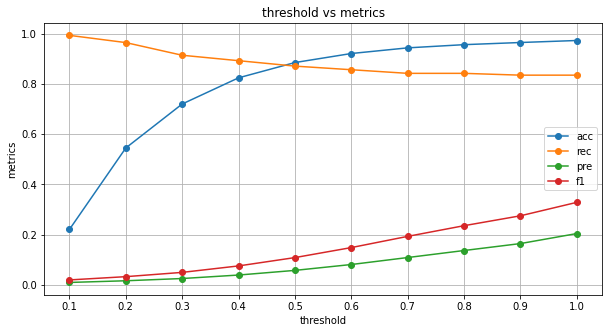

In [310]:
trial_threshold = np.arange(0.1, 1.1, 0.1)
IF_acc_list = []
IF_rec_list = []
IF_pre_list = []
IF_f1_list = []

for threshold in trial_threshold:
    y_pred = []
    for orig in X_test_1.values:
        error = reconstruction_error(orig, model)
        if error < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
    IF_acc_list.append(accuracy_score(y_test_1, y_pred))
    IF_rec_list.append(recall_score(y_test_1, y_pred))
    IF_pre_list.append(precision_score(y_test_1, y_pred))
    IF_f1_list.append(f1_score(y_test_1, y_pred))
    
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(trial_threshold, IF_acc_list, marker = 'o', label = 'acc')
ax1.plot(trial_threshold, IF_rec_list, marker = 'o', label = 'rec')
ax1.plot(trial_threshold, IF_pre_list, marker = 'o', label = 'pre')
ax1.plot(trial_threshold, IF_f1_list, marker = 'o', label = 'f1')
ax1.set_xticks(trial_threshold)
ax1.set_xlabel('threshold')
ax1.set_ylabel('metrics')
ax1.grid()
ax1.legend()
ax1.set_title('threshold vs metrics')

plt.show()

In [313]:
y_pred = []
for orig in X_test_2.values:
    error = reconstruction_error(orig, model)
    if error < 0.5:
        y_pred.append(0)
    else:
        y_pred.append(1)
print(f'Accuracy: {accuracy_score(y_test_2, y_pred)}\n Recall: {recall_score(y_test_2, y_pred)}\n Precision: {precision_score(y_test_2, y_pred)}\n F1 score: {f1_score(y_test_2, y_pred)}')
print(confusion_matrix(y_test_2, y_pred))


Accuracy: 0.8823867757021032
 Recall: 0.9281437125748503
 Precision: 0.06213670074163159
 F1 score: 0.11647567161375165
[[34974  4679]
 [   24   310]]


**Remark**

Because the training, val and test data for the two supervised machine learning models (MLP and gradient boosting) are the same, their results are directly comparable. They roughly have the same performence: both got a recall of ~93%. Due to the different ways of splitting the data for the unsupervised models, their results are not directly comparable.

For the unsupervised models, a general trend is that there is always a trade-off between precision and recall. If the criterion of regarding a transaction as fraudulent is higher, there is generally a higher precision but lower recall and vice versa. The precision is generally low because the test data is very imbalanced, which resembles the real world data. Depends on what our goal is we may choose an appropriate value for the parameter to achieve our goal. For instance, in one real world situation we may decide to detect as much positive samples as possible even in the cost of having a bit more false positives. Then we may use other procedures or human intervention to further investigate the transactions in these candidates that are far less than the original number of transactions and send a warning to the holder of the credit card with suspicious transactions. In this case, we may prefer a relatively higher recall.